# e3ferminet
E(3)-equivariant neural network ansatz for atomic and molecular VMC calculations

#Background

In computational chemistry, solving the ground state wavefunction of a molecule allows us to predict its properties accurately.
However, an exact solution to the wavefunction is computationally infeasible for these quantum many-body systems,
and various approximation methods have been proposed and studied over the last few decades.
A classical method is the variational Monte Carlo method (VMC).
VMC is a variant of the variational method, which identifies the ground state energy $E_0$ as the minimum of the energy functional
\begin{equation}
    E[\psi] = \frac{\langle \psi| \hat H |\psi\rangle}{\langle \psi | \psi \rangle} = \frac{\int dx\, |\psi(x)|^2 \frac{\hat H\psi(x)}{\psi(x)}}{\int dx\, |\psi(x)|^2},
\end{equation}

The value of the energy functional is lower-bounded by the ground state energy, so the variational method seeks to find better and better approximations for $E_0$ by guessing and refining an ansatz. The energy functional can then be computed by sampling points from $p(x) \propto |\psi(x)|^2$ to estimate the expectation value of $\frac{\hat H\psi(x)}{\psi(x)}$. The main difficulty remains in finding a good ansatz.

One standard choice in VMC is to guess a wavefunction of the Slater-Jastrow type. This consists of a Slater determinant multiplied by a Jastrow factor (typically of the form $e^{J}$, with $J= \sum_{ij} u_{ij}(|r_i - r_j|)$, i.e. a function of all pairwise distances to account for electron correlation. For example, the wavefunction ansatz PauliNet developed by Noe et al. uses a preliminary Hartree-Fock calculation as an input and expressiveness comes from the Jastrow factor and a backflow transformation, both represented as DNNs. However, one benefit of neural networks is that we don't need to be restricted to wavefunctions of this form, which have limitations such as being constrained to a finite basis set.

In [this](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.2.033429) paper, the authors used an ansatz parameterized by a neural network, and by performing gradient descent with $E[\psi]$ as the loss function, they were able to accurately recover the ground state wavefunctions of a few small but challenging molecules. In this project, we will explore the potential of using an $E(3)$-equivariant neural network to parameterize the wavefunction. We will start by investigating single atoms. 


## Single atom wavefunction
Let's first study a single atom of atomic number $Z$. For $n$ electrons, the Hamiltonian is
$$
\hat H = -\frac{1}{2} \sum_i \nabla_i^2 - \sum_i \frac{Z}{r_i} + \sum_{i<j} \frac{1}{|\mathbf r_i - \mathbf r_j|}.
$$
We'll parameterize the multi-electron wavefunction $\psi(\mathbf r_1, \ldots, \mathbf r_n)$ with a neural network $\phi_\theta(\mathbf r_1, \ldots, \mathbf r_n)$ that is $SO(3)$-equivariant in each input $\mathbf r_i$, where we obtain $\psi$ by antisymmetrizing $\phi_\theta$:
$$
\psi(\mathbf r_i, \ldots, \mathbf r_n) = \sum_{\sigma \in S(n_\uparrow) \times S(n_\downarrow)} \mathrm{sgn}(\sigma) \phi_\theta(\mathbf r_{\sigma(1)}, \ldots, \mathbf r_{\sigma(n)}).
$$
The sum is over all products of permutations of $n_\uparrow$ spin-up electrons with permutations of $n_\downarrow$ spin-down electrons, where $n_\uparrow + n_\downarrow = n$, where WLOG we label the spin-up electrons as $1, \ldots, n_\uparrow$ and the spin-down electrons as $n_\uparrow + 1, \ldots, n$.

For computing the expected energy in the state $\psi$, we will for now use Monte Carlo integration since we don't yet have an efficient way of sampling from the distribution $p(X) \propto |\psi(X)|^2$. In other words, we sample many points $X_i = (\mathbf r_{i1}, \ldots, \mathbf r_{in})$ where each $\mathbf r_{ij}$ is chosen uniformly and independently from a ball of a certain radius $r_{max}$. We then approximate
$$
E[\psi] \approx \frac{\sum_i \psi(X_i)^* \hat H\psi(X_i)}{\sum_i \psi(X_i)^* \psi(X_i)}.
$$
To implement the boundary condition $\psi \to 0$ as $|X| \to \infty$, we will add a regularization term that penzalizes large values of $|\psi|$ near $r = r_{\max}$ by adding a regularization term $\lambda \sum_i |\frac{r_i}{r_{max}}|^\beta$ for some large exponent $\beta$ to the Hamiltonian.

Finally, we perform gradient descent with
$$
\theta \gets \theta - \alpha \Delta_\theta E[\psi]
$$
to find the ground state.

In [ ]:
%%capture
!pip install e3nn-jax

In [ ]:
import numpy as np
from tqdm import tqdm
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, jacobian
import flax
import optax
import matplotlib.pyplot as plt

import e3nn_jax as e3nn  # import e3nn-jax

jnp.set_printoptions(precision=4, suppress=True)

print(jax.__version__)
print(flax.__version__)
print(optax.__version__)
print(e3nn.__version__)
print(jnp.ones(()).device())

0.4.8
0.6.8
0.1.4
0.17.3
gpu:0


### Hydrogen

As a proof of concept, we'll first try predicting the hydrogen atom ground state wavefunction. We'll use a simple MLP with a single hidden layer with 5 neurons, where the input is $|\mathbf r|^2$.

In [ ]:
# Set up model

mlp_H = e3nn.flax.MultiLayerPerceptron([5, 1], act=jax.nn.gelu, output_activation=jax.nn.sigmoid)
N_samples = 2000
max_r = 4
regularize_pow = 8
regularize_coeff = 100

def wavefunction_H(w, in_points):
  return mlp_H.apply(w, e3nn.tensor_square(e3nn.IrrepsArray("1o", in_points)).filter(keep="0e")).array.squeeze(-1)

@jit
def energy_H(w, in_points):
  psi = wavefunction_H(w, in_points)
  @vmap
  def laplacian(in_points):
    return jnp.einsum('ii->', jacobian(jacobian(wavefunction_H, argnums=1), argnums=1)(w, in_points))
  laplacian_psi = laplacian(in_points)
  cum_K = -0.5 * jnp.dot(psi, laplacian_psi)
  distances = jnp.linalg.norm(in_points, axis=1)
  cum_V = -jnp.dot(psi, psi / distances)
  return (cum_K + cum_V) / jnp.dot(psi, psi)

@jit
def regularized_energy_H(w, in_points):
  psi = wavefunction_H(w, in_points)
  distances = jnp.linalg.norm(in_points, axis=1)
  return energy_H(w, in_points) + regularize_coeff * jnp.dot(psi, psi * (distances / max_r) ** regularize_pow) / jnp.dot(psi, psi)  # penalize high probability near max_r


In [ ]:
random_key = jax.random.PRNGKey(0)
in_points = jax.random.ball(random_key, 3, shape=(N_samples,)) * max_r
random_key += 1
x = e3nn.IrrepsArray("1o", in_points)
x = e3nn.tensor_square(x).filter(keep="0e")

w = mlp_H.init(random_key, x)
random_key += 1
%timeit print(jit(regularized_energy_H)(w, in_points))

21.280561
21.280561
21.280561
21.280561
21.280561
21.280561
21.280561
21.280561
1.08 ms ± 228 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# Training loop

grad_energy = jit(grad(regularized_energy_H))

optimizer = optax.adam(learning_rate=0.1)
opt_state = optimizer.init(w)

weights = [w]
energy_moving_avgs = [energy_H(w, in_points)]
for step in tqdm(range(1000)):
  in_points = jax.random.ball(random_key, 3, shape=(N_samples,)) * max_r
  random_key += 1
  grads = grad_energy(w, in_points)
  updates, opt_state = optimizer.update(grads, opt_state, w)
  w = optax.apply_updates(w, updates)
  weights.append(w)
  energy_moving_avgs.append(energy_moving_avgs[-1] * 0.8 + energy_H(w, in_points) * 0.2)
  # print(energies[-1])
  if step - np.argmin(energy_moving_avgs) >= 100:
    break

 26%|██▌       | 262/1000 [00:15<00:44, 16.43it/s]


BEST INDEX: 162
GROUND STATE ENERGY: -0.4406


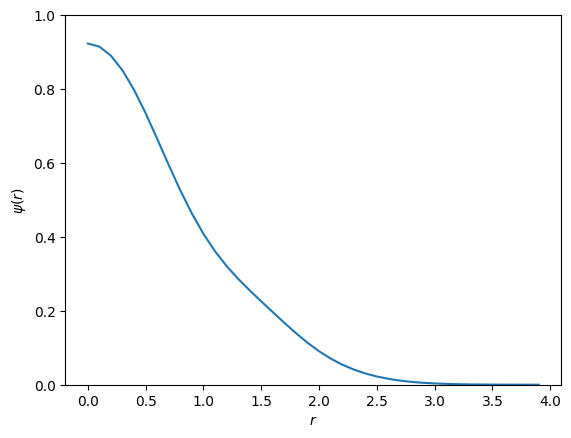

In [ ]:
# Plot results
test_N_samples = 10000

best_idx = np.argmin(energy_moving_avgs)
print(f"BEST INDEX: {best_idx}")
in_points = jax.random.ball(random_key, 3, shape=(test_N_samples,)) * max_r
random_key += 1
print("GROUND STATE ENERGY: {:.4f}".format(energy_H(weights[best_idx], in_points)))  # should be -0.5
distances = jnp.arange(0, 4, 0.1)
in_points = jnp.array([[i, 0, 0] for i in distances])
plt.xlabel("$r$")
plt.ylabel("$\psi(r)$")
plt.ylim([0, 1])
plt.plot(distances, wavefunction_H(w, in_points))

#Importance Sampling

One source of inaccuracy in the Monte Carlo integration is that we were sampling from a uniform ball. But this over-prioritizes points far away from the origin, and points near the nucleus don't get sampled enough. This creates a large variance in the integral. We want to try importance sampling, where we sample from a known distribution and calculate the Hamiltonian at those points. Then each sample gets weighted. This works as follows:

Suppose we are trying to sample the energy $E(x)$ from a distribution $p(x)$, and we want to calculate
$$\langle E \rangle = \int E(x)p(x)dx$$
but $p(x)$ is difficult to sample from (or may not even be normalized!). We pick a sampling distribution $q(x)$, and calculate
$$\int E(x)p(x)dx=\int E(x)q(x)\frac{p(x)}{q(x)}dx \approx \sum_i E(x_i) \frac{p(x)}{q(x)}$$
where the points $x_i$ are sampled from $q$. In the case of the hydrogen atom, the radial distribution function is close enough to a $\chi$-squared distribution, so we use that as a sampling distribution.

In [ ]:
# Set up model

mlp_H = e3nn.flax.MultiLayerPerceptron([5, 1], act=jax.nn.gelu, output_activation=jax.nn.sigmoid)
N_samples = 20000
max_r = 4
regularize_pow = 8
regularize_coeff = 100


def wavefunction_H(w, in_points):
  return mlp_H.apply(w, e3nn.tensor_square(e3nn.IrrepsArray("1o", in_points)).filter(keep="0e")).array.squeeze(-1)

def pdf(in_points):
  '''
  A chi-square distribution with k = 4 degrees of freedom, and scaled to have
  mode at x = 1
  '''
  x = jnp.linalg.norm(in_points, axis = 1, keepdims = False)
  return jnp.exp(-x**2 / (2 * 2**2))
  return jnp.multiply(1 / x, jnp.exp(-x))

@jit
def energy_H_fromdist(w, in_points):
  '''
  Calculate H sampled from a known distribution (as pdf)
  '''

  psi = wavefunction_H(w, in_points)
  q = pdf(in_points) + 1e-9 #the sampling distribution
  @vmap
  def laplacian(in_points):
    return jnp.einsum('ii->', jacobian(jacobian(wavefunction_H, argnums=1), argnums=1)(w, in_points))

  scale_factor = (jnp.abs(psi))**2 / q
  normalizer = jnp.sum(scale_factor)

  laplacian_psi = laplacian(in_points)
  cum_K = -0.5 * jnp.dot(1 / psi, laplacian_psi * scale_factor)

  distances = jnp.linalg.norm(in_points, axis=1)
  cum_V = -jnp.dot(scale_factor,  1 / distances)
  #return (cum_K + cum_V) / jnp.dot(psi, psi)
  return ((cum_K + cum_V) / normalizer)

@jit
def kinetic_energy_H_fromdist(w, in_points):
  '''
  Calculate H sampled from a known distribution (as pdf)
  '''

  psi = wavefunction_H(w, in_points)
  q = pdf(in_points) + 1e-9 #the sampling distribution
  @vmap
  def laplacian(in_points):
    return jnp.einsum('ii->', jacobian(jacobian(wavefunction_H, argnums=1), argnums=1)(w, in_points))

  scale_factor = (jnp.abs(psi))**2 / q
  normalizer = jnp.sum(scale_factor)

  laplacian_psi = laplacian(in_points)
  cum_K = -0.5 * jnp.dot(1 / psi, laplacian_psi * scale_factor)
  return cum_K / normalizer

@jit
def potential_energy_H_fromdist(w, in_points):
  '''
  Calculate H sampled from a known distribution (as pdf)
  '''

  psi = wavefunction_H(w, in_points)
  q = pdf(in_points) + 1e-9 #the sampling distribution
  scale_factor = (jnp.abs(psi))**2 / q
  normalizer = jnp.sum(scale_factor)

  distances = jnp.linalg.norm(in_points, axis=1)
  cum_V = -jnp.dot(scale_factor, 1 / distances)
  #return (cum_K + cum_V) / jnp.dot(psi, psi)
  return cum_V / normalizer

@jit
def regularized_energy_H_fromdist(w, in_points):
  psi = wavefunction_H(w, in_points)
  distances = jnp.linalg.norm(in_points, axis=1)
  return energy_H_fromdist(w, in_points) + regularize_coeff * jnp.dot(psi, psi * (distances / max_r) ** regularize_pow) / jnp.dot(psi, psi)  # penalize high probability near max_r

In [ ]:
random_key = jax.random.PRNGKey(0)
# in_points = jax.random.ball(random_key, 3, shape=(N_samples,))
# in_points = in_points / (jax.numpy.linalg.norm(in_points, axis = 1, keepdims = True))
# radial = 0.5*jax.random.chisquare(random_key, 4, (N_samples, 1))
# print(radial)
# in_points = in_points * radial
# print(in_points)

# print(pdf(in_points))

in_points = jax.random.normal(random_key, (2000, 3)) * 2

random_key += 1
x = e3nn.IrrepsArray("1o", in_points)
x = e3nn.tensor_square(x).filter(keep="0e")

w = mlp_H.init(random_key, x)
random_key += 1
print(jit(regularized_energy_H_fromdist)(w, in_points))
print(jit(energy_H_fromdist)(w, in_points))
print(jit(kinetic_energy_H_fromdist)(w, in_points))
print(jit(potential_energy_H_fromdist)(w, in_points))


84.88478
-0.22015537
0.05314476
-0.2733001


In [ ]:
# Training loop

# grad_energy = jit(grad(energy_H_fromdist))
grad_energy = jit(grad(regularized_energy_H_fromdist))

optimizer = optax.adam(learning_rate=0.1)
opt_state = optimizer.init(w)

print(energy_H_fromdist(w, in_points))

weights = [w]
energy_moving_avgs = [energy_H_fromdist(w, in_points)]
for step in tqdm(range(1000)):
  # in_points = jax.random.ball(random_key, 3, shape=(N_samples,))
  # in_points = in_points / (jax.numpy.linalg.norm(in_points, axis = 1, keepdims = True))
  # radial = 0.5*jax.random.chisquare(random_key, 4, (N_samples, 1))
  # in_points = in_points * radial
  in_points = jax.random.normal(random_key, (N_samples, 3))
  random_key += 1

  grads = grad_energy(w, in_points)
  updates, opt_state = optimizer.update(grads, opt_state, w)
  w = optax.apply_updates(w, updates)
  weights.append(w)
  energy_moving_avgs.append(energy_moving_avgs[-1] * 0.8 + energy_H_fromdist(w, in_points) * 0.2)
  # if step%10 == 0:
  #   print(energy_moving_avgs[-1])
  if step - np.argmin(energy_moving_avgs) >= 200:
    break

-0.22015537


 70%|██████▉   | 695/1000 [00:25<00:11, 27.25it/s]


BEST INDEX: 495
GROUND STATE ENERGY: -0.4204
-0.622943
0.6098167
-1.2327596


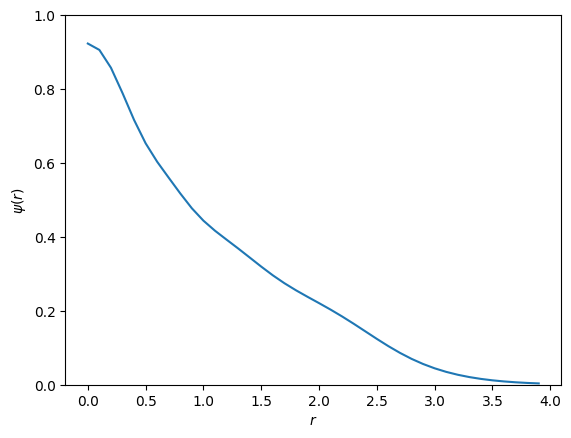

In [ ]:
# Plot results
test_N_samples = 50000

best_idx = np.argmin(energy_moving_avgs)
print(f"BEST INDEX: {best_idx}")

in_points = jax.random.ball(random_key, 3, shape=(test_N_samples,)) * max_r
random_key += 1
print("GROUND STATE ENERGY: {:.4f}".format(energy_H(weights[best_idx], in_points)))  # should be -0.5

# in_points = jax.random.ball(random_key, 3, shape=(N_samples,))
# in_points = in_points / (jax.numpy.linalg.norm(in_points, axis = 1, keepdims = True))
# radial = 0.5*jax.random.chisquare(random_key, 4, (N_samples, 1))
# in_points = in_points * radial

# random_key += 1
# print("GROUND STATE ENERGY: {:.4f}".format(energy_H_fromdist(weights[best_idx], in_points)))  # should be -0.5
distances = jnp.arange(0, 4, 0.1)
in_points = jnp.array([[i, 0, 0] for i in distances])
plt.xlabel("$r$")
plt.ylabel("$\psi(r)$")
plt.ylim([0, 1])
plt.plot(distances, wavefunction_H(w, in_points))

in_points = jax.random.normal(random_key, (2000, 3))
# in_points = jax.random.ball(random_key, 3, shape=(N_samples,))
# in_points = in_points / (jax.numpy.linalg.norm(in_points, axis = 1, keepdims = True))
# radial = 0.5*jax.random.chisquare(random_key, 4, (N_samples, 1))
# in_points = in_points * radial
print(energy_H_fromdist(weights[best_idx], in_points))
print(kinetic_energy_H_fromdist(weights[best_idx], in_points))
print(potential_energy_H_fromdist(weights[best_idx], in_points))


### Helium

Now, let's try the helium atom, which is the most electrons we can have before we have to introduce antisymmetrization. We'll use a simple MLP with two hidden layers with 5 neurons each, where the inputs to the MLP are scalars $|\mathbf r_1|^2$, $|\mathbf r_2|^2$, and $\mathbf r_1 \cdot \mathbf r_2$.

In [ ]:
# Set up model

mlp_He = e3nn.flax.MultiLayerPerceptron([5, 5, 1], act=jax.nn.gelu, output_activation=jax.nn.sigmoid)
N_samples = 20000
max_r = 2
regularize_pow = 8
regularize_coeff = 100

def wavefunction_He(w, in_points):
  x = e3nn.tensor_square(e3nn.IrrepsArray("2x1o", in_points)).filter(keep="0e")
  return mlp_He.apply(w, x).array.squeeze(-1)

@jit
def energy_He(w, in_points):
  psi = wavefunction_He(w, in_points)
  @vmap
  def laplacian(in_points):
    return jnp.einsum('ii->', jacobian(jacobian(wavefunction_He, argnums=1), argnums=1)(w, in_points))
  laplacian_psi = laplacian(in_points)
  cum_K = -0.5 * jnp.dot(psi, laplacian_psi)
  r1 = in_points[:,0:3]
  r2 = in_points[:,3:6]
  dist1 = jnp.linalg.norm(r1, axis=1)
  dist2 = jnp.linalg.norm(r2, axis=1)
  cum_V_e_p = -2 * jnp.dot(psi, psi * (1 / dist1 + 1 / dist2))
  dist_e = jnp.linalg.norm(r1 - r2, axis=1)
  cum_V_e_e = jnp.dot(psi, psi / dist_e)
  # print(cum_K, cum_V_e_p, cum_V_e_e, jnp.dot(psi, psi))
  return (cum_K + cum_V_e_p + cum_V_e_e) / jnp.dot(psi, psi)

@jit
def regularized_energy_He(w, in_points):
  psi = wavefunction_He(w, in_points)
  r1 = in_points[:,0:3]
  r2 = in_points[:,3:6]
  dist1 = jnp.linalg.norm(r1, axis=1)
  dist2 = jnp.linalg.norm(r2, axis=1)
  return energy_He(w, in_points) + regularize_coeff * jnp.dot(psi**2, (dist1 / max_r) ** regularize_pow + (dist2 / max_r) ** regularize_pow) / jnp.dot(psi, psi)  # penalize high probability near max_r

In [ ]:
random_key = jax.random.PRNGKey(0)
in_points = jax.random.ball(random_key+2, 3, shape=(2 * N_samples,)).reshape((N_samples, -1)) * max_r
random_key += 1
x = e3nn.IrrepsArray("2x1o", in_points)
x = e3nn.tensor_square(x).filter(keep="0e")

# print(energy_He(w, in_points))
w = mlp_He.init(random_key, x)
random_key += 1
%timeit print(jit(regularized_energy_He)(w, in_points))

49.782505
49.782505
49.782505
49.782505
49.782505
49.782505
49.782505
49.782505
5.48 ms ± 85.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# Training loop

grad_energy = jit(grad(regularized_energy_He))

optimizer = optax.adam(learning_rate=0.1)
opt_state = optimizer.init(w)

weights = [w]
energy = energy_He(w, in_points)
# energies = [energy]
energy_moving_avgs = [energy]
for step in tqdm(range(1000)):
  in_points = jax.random.ball(random_key, 3, shape=(2 * N_samples,)).reshape((N_samples, -1)) * max_r
  random_key += 1
  grads = grad_energy(w, in_points)
  updates, opt_state = optimizer.update(grads, opt_state, w)
  w = optax.apply_updates(w, updates)
  weights.append(w)
  # print(regularized_energy_He(w, in_points))
  energy = energy_He(w, in_points)
  # energies.append(energy)
  energy_moving_avgs.append(energy_moving_avgs[-1] * 0.8 + energy * 0.2)
  # print(energies[-1])
  if step - np.argmin(energy_moving_avgs) >= 200:
    break

 20%|██        | 201/1000 [00:20<01:19, 10.05it/s]


BEST INDEX: 1
GROUND STATE ENERGY: -2.2700


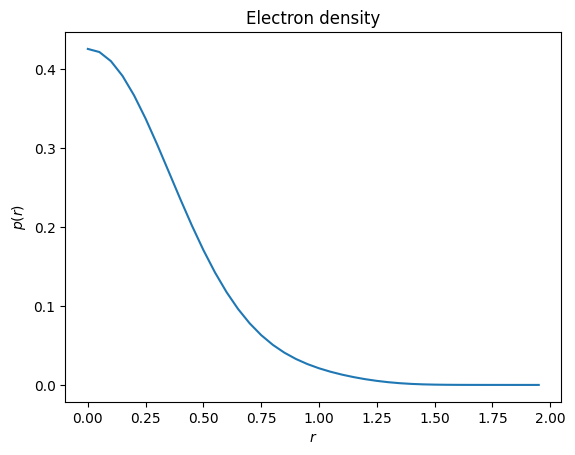

In [ ]:
# Plot results
plot_samples = 500
test_N_samples = 50000

best_idx = np.argmin(energy_moving_avgs)
# best_idx = 100
print(f"BEST INDEX: {best_idx}")
in_points = jax.random.ball(random_key, 3, shape=(2 * test_N_samples,)).reshape((test_N_samples, -1)) * max_r
random_key += 1
print("GROUND STATE ENERGY: {:.4f}".format(energy_He(weights[best_idx], in_points)))  # should be -2.9
distances = jnp.arange(0, max_r, max_r / 40)
densities = []
for d in distances:
  in_points1 = jax.random.ball(random_key, 3, shape=(plot_samples,))
  in_points1 = in_points1 / jnp.linalg.norm(in_points1, axis=1).reshape((plot_samples, 1)) * d
  random_key += 1
  in_points2 = jnp.zeros((plot_samples, 3))
  # in_points2 = jax.random.ball(random_key, 3, shape=(plot_samples,))
  in_points = jnp.hstack([in_points1, in_points2])
  random_key += 1
  densities.append((wavefunction_He(w, in_points) ** 2).sum() / (2 * plot_samples))
plt.xlabel("$r$")
plt.ylabel("$p(r)$")
plt.title("Electron density")
# plt.ylim([-1, 1])
plt.plot(distances, densities)

Although decently accurate for hydrogen, there's still some distance to the true ground state energy for helium! Here are some possible approaches for improving our accuracy:
- More expressive neural network, e.g. including biases, more layers, more neurons...
- More efficient and accurate sampling
- Better way to impose wavefunction boundary conditions

We have only been using real-valued wavefunctions so far, which is a big limitation as well. So we should probably allow complex-valued wavefunctions sometime soon.

The [paper](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.2.033429) we're referencing has some quite sophisticated techniques for wavefunction parameterization and optimization, and we're considering incorporating some of them into our model.

# NEXT STEPS

Zed: Continue with current approach
- Refactor
- Implement MH and importance sampling
- Implement envelope

Alec: Equivariant basis function approach

Input $\mathbf R_A$ (positions of all nuclei) (or relative distances?).
Neural network outputs coefficients $c_i$ so that output wavefunction is
$$
\psi = \sum_i c_i \psi_i
$$
Approach 1:
Each electron has a molecular orbital $$\phi_i$$ written as a linear combination of equivariant basis functions
$$
\phi_i = \sum_j c_{ij}{}^l_m B_j{}^l_m
$$
where
$$
B_j{}^l_m = R_j(r) Y^l_m.
$$
(We let origin be arbitrariy, or some "important" atom of the molecule for now.)
The $c_{ij}{}^l_m$ for fixed $i, j, l$ transforms as an $l$-irrep.

Radial basis $R(r)$ can be e.g. Bessel functions multiplied by an exponentially decaying envelope, or radial part of Slater-type orbitals, or radial part of Gaussian orbitals, or even a neural network. These choices may also involve a continuous parameter in the exponent that we optimize.

The final wavefunction is the Slater determinant of molecular orbitals.

Approach 2:
Do Approach 1 around every atom, and sum up all wavefunctions.
So we have a wavefunction $\psi_A$ derived from Approach 1 around each atom, and sum everything together: $\psi = \sum_A \psi_A$.

### Atoms with more electrons?

Beyond helium, we'll have to antisymmetrize the wavefunction for electrons with the same spin. We'll explore this in the next few days.

# Molecules with multiple atoms

If our $SO(3)$-equivariant neural network ansatz works well, we will try to extend our approach to molecules with multiple atoms. Exact details TBD.

#Implementing Equivariance
As a proof of concept, we will implement equivariance on the hydrogen atom. We take the total wavefunction to be the product of a radial part and an angular part, consisting of spherical harmonics which transform eqivariantly. The radial part as before will be invariant.

In [ ]:
# Set up model

radial = e3nn.flax.MultiLayerPerceptron([5, 1], act=jax.nn.gelu, output_activation=jax.nn.sigmoid)
angular = e3nn.flax.MultiLayerPerceptron([5, 1], act=jax.nn.gelu, output_activation=jax.nn.sigmoid)
N_samples = 2000
max_r = 4
regularize_pow = 8
regularize_coeff = 100

def wavefunction_H(w, in_points):
  return mlp_H.apply(w, e3nn.tensor_square(e3nn.IrrepsArray("1o", in_points)).filter(keep="0e")).array.squeeze(-1)

@jit
def energy_H(w, in_points):
  psi = wavefunction_H(w, in_points)
  @vmap
  def laplacian(in_points):
    return jnp.einsum('ii->', jacobian(jacobian(wavefunction_H, argnums=1), argnums=1)(w, in_points))
  laplacian_psi = laplacian(in_points)
  cum_K = -0.5 * jnp.dot(psi, laplacian_psi)
  distances = jnp.linalg.norm(in_points, axis=1)
  cum_V = -jnp.dot(psi, psi / distances)
  return (cum_K + cum_V) / jnp.dot(psi, psi)

@jit
def regularized_energy_H(w, in_points):
  psi = wavefunction_H(w, in_points)
  distances = jnp.linalg.norm(in_points, axis=1)
  return energy_H(w, in_points) + regularize_coeff * jnp.dot(psi, psi * (distances / max_r) ** regularize_pow) / jnp.dot(psi, psi)  # penalize high probability near max_r


In [ ]:
random_key = jax.random.PRNGKey(0)
in_points = jax.random.ball(random_key, 3, shape=(N_samples,)) * max_r
random_key += 1
x = e3nn.IrrepsArray("1o", in_points)
x = e3nn.tensor_square(x).filter(keep="0e")

w = mlp_H.init(random_key, x)
random_key += 1
%timeit print(jit(regularized_energy_H)(w, in_points))